# 基于DDPG算法的电磁式阻尼器控制

本笔记本实现了基于DDPG算法的二自由度电磁阻尼器控制系统。参数来源于MATLAB仿真文件，方法迁移自《数据驱动的动力学系统建模及控制策略研究》。

## 外部依赖及参数设置

### 导入外部依赖

In [1]:
import inspect
import numpy as np
import torch
import matplotlib.pyplot as plt
from datetime import datetime
import os
import json
import logging
# from pathlib import Path
# 设置随机种子，保证结果可重现
# import random
# seed = 42
# random.seed(seed)
# np.random.seed(seed)
# torch.manual_seed(seed)

### 编程环境搭建

In [2]:
train_model = False # 训练模式开关

from env import ElectromagneticDamperEnv # 自定义环境
from ddpg_agent import DDPGAgent, ReplayBuffer # DDPG智能体和经验回放缓冲区
from train import train_ddpg # 训练函数
from af import plot_rewards, plot_state_comparison, plot_data, plot_test_data # 绘图函数
from af import load_checkpoint # 加载检查点函数
from rewardfx import select_dimensions

# 设置中文字体
plt.rcParams['font.family'] = ['SimHei', 'Arial']

# 检查CUDA是否可用
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"使用设备: {device}")

# 创建保存模型的基础目录
base_dir = "./savedata"
os.makedirs(base_dir, exist_ok=True)

# 确认训练保存目录
current_time = datetime.now().strftime("%Y%m%d_%H%M%S")

project_name = input("请输入加载/创建项目的名称 (父目录: ./savedata) ").strip()

save_dir = os.path.join(base_dir, project_name)
is_new_project = not os.path.exists(save_dir)
os.makedirs(save_dir, exist_ok=True)
save_checkpoint_path = os.path.join(save_dir, "checkpoints")
os.makedirs(save_checkpoint_path, exist_ok=True)
save_plot_path = os.path.join(save_dir, "plots")
os.makedirs(save_plot_path, exist_ok=True)

# 创建日志文件
if not is_new_project:
    assign_log = input("是否指定日志文件？(路径/n) ").strip().lower()
    if assign_log == 'n' or assign_log == '':
        file_path = save_dir + f'\\training_log_{current_time}.log'
    else:
        file_path = assign_log
        if not os.path.exists(os.path.dirname(file_path)):
            os.makedirs(os.path.dirname(file_path))
else:
    file_path = save_dir + f'\\training_log_{current_time}.log'

logging.basicConfig(filename=file_path,  # 如果指定日志文件，则使用指定路径，否则不写入文件
                level=logging.INFO,          # 设置日志级别
                format='%(asctime)s - %(levelname)s - %(message)s')  # 设置日志格式
logging.info("## 当前时间: %s", datetime.now())
logging.info("项目保存目录: %s", save_dir)
logging.info("日志文件: %s", file_path)
logging.info("训练模式: %s", train_model)
logging.info("模型保存目录: %s", save_checkpoint_path)
logging.info("绘图保存目录: %s", save_plot_path)
logging.info("使用设备: %s", device)

使用设备: cuda


### 超参数设置

In [3]:
# 仿真环境设置
T = 10
Ts = 0.01
tolerance = 1e-4 # 误差容忍度
all_state0 = np.array([0.0, 0.0, 0.0, 0, 0.01, 0.0]) # 初始状态
x1_limit = 0.001
# DDPG智能体设置
hidden_dim=64 # 隐藏层维度
action_bound=5 # 动作范围
actor_lr=5e-4 # Actor学习率
critic_lr=1e-3 # Critic学习率
gamma=0.98 # 折扣因子
tau=5e-3 # 软更新参数
sigma=0.1 # 初始噪声标准差
clip_grad=True # 是否裁剪梯度
# 经验池设置
capacity= int(1e6) # 经验池容量
batch_size=128 # 批量大小
# 训练超参数
rand_prob = 0.05 # 随机动作概率
n_episodes = 400 # 训练轮数
min_buffer_size = int(5e3) # 最小经验池大小
print_interval = 5 # 打印间隔
save_interval = 5 # 保存间隔

# 观测状态列表
# 0: 吸振器位移 (x1)
# 1: 吸振器速度 (v1)
# 2: 吸振器加速度 (a1)
# 3: 平台位移 (x2)
# 4: 平台速度 (v2)
# 5: 平台加速度 (a2)

observation_indices = [0,2,3,5]  # 观测状态索引

### 系统参数设置

从MATLAB仿真文件中提取二自由度电磁阻尼器系统的参数。

In [4]:
# 系统参数（来自MATLAB文件）
m = 1.6    # 电磁吸振器质量
M = 100.0  # 待减振对象质量
k_m = 3000  # 电磁吸振器刚度
k_M = 20000.0  # 平台刚度
k_f = 45.0  # 电—力常数 N/A
k_E = 0.0  # 作动器反电动势系数
L = 0.0045  # 线圈的电感
R_m = 5.0  # 线圈的电阻
c_m = 1.0  # 电磁吸振器阻尼
c_M = 5.0  # 平台阻尼

# 状态空间矩阵（来自MATLAB文件）
A = np.array([
    [0.0,    1.0,       0.0,         0.0],
    [-k_m/m, -c_m/m,    k_m/m,       c_m/m],
    [0.0,    0.0,       0.0,         1.0],
    [k_m/M,  c_m/M,     -(k_m+k_M)/M, -(c_m+c_M)/M]
])

B = np.array([[0.0], [k_f/m], [0.0], [-k_f/M]])

C = np.array([
    [-k_m/m, -c_m/m,    k_m/m,       c_m/m],
    [k_m/M,  c_m/M,     -(k_m+k_M)/M, -(c_m+c_M)/M]
])

D = np.array([[+k_f/m], [-k_f/M]])

E = np.array([
    [0.0, 0.0, 0.0, c_M/M],
    [0.0, 0.0, 0.0, k_M/M]
]).T

### 无控制输出环境验证

仿真进度: 10001it [00:00, 19890.62it/s]                          


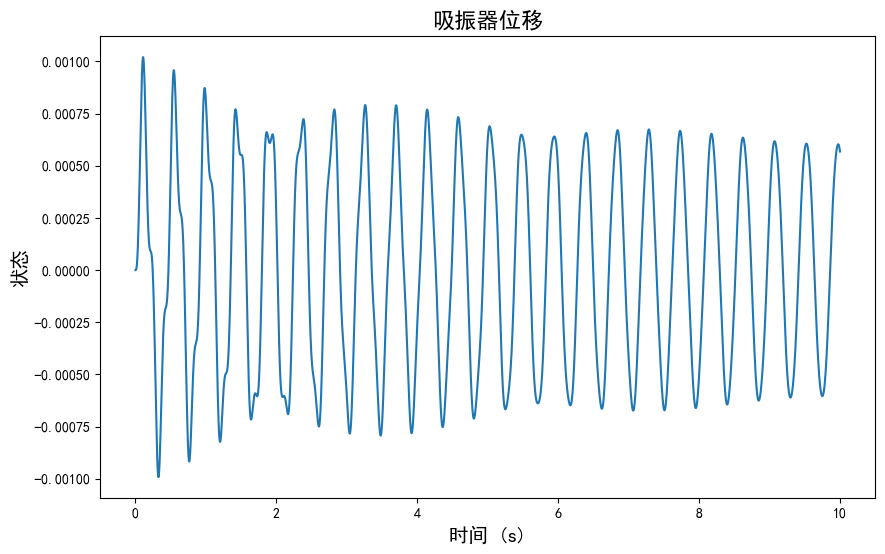

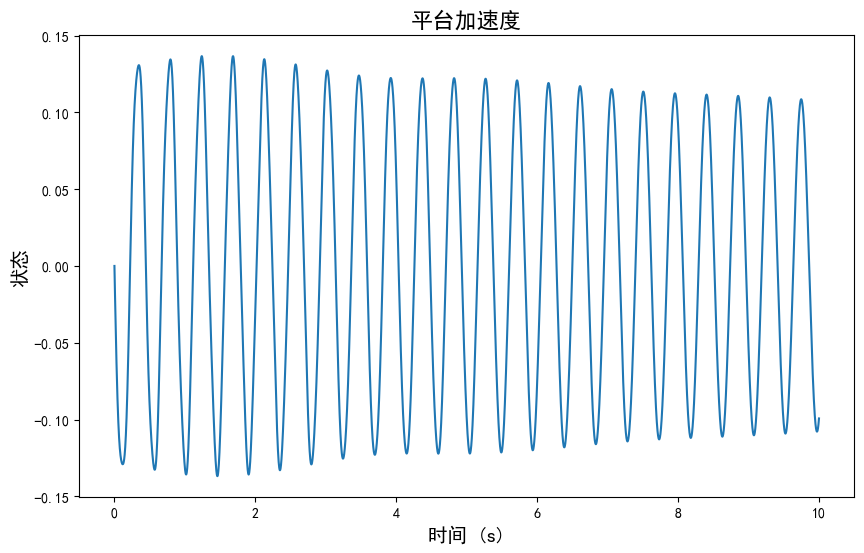

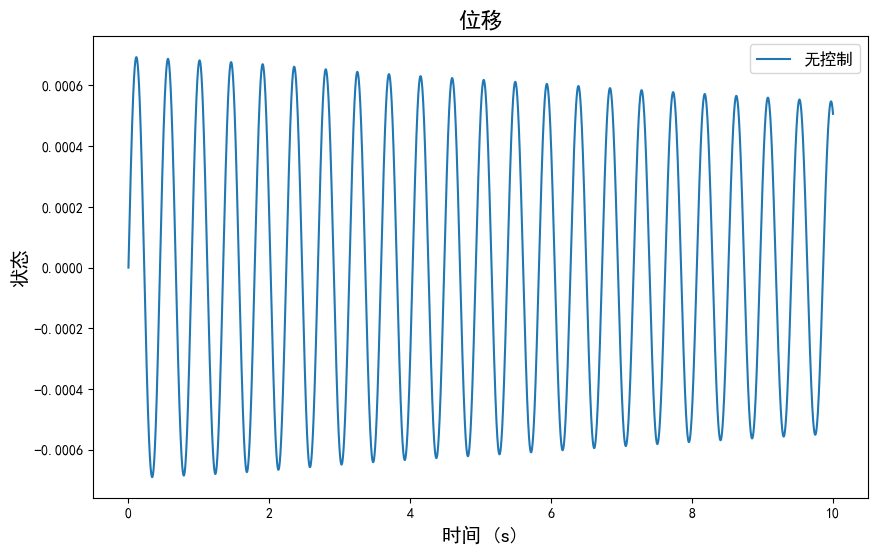

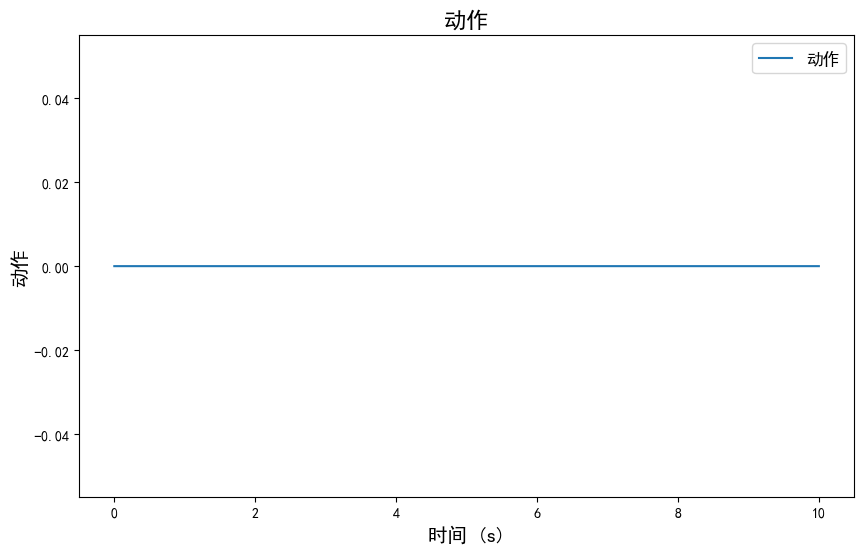

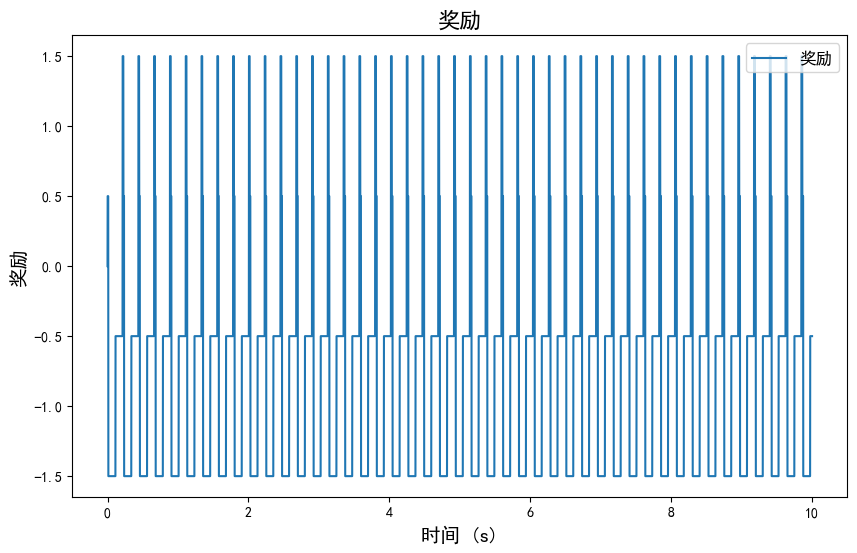

In [5]:
rl_env = ElectromagneticDamperEnv(A, B, C, D, E, Ts=0.001, T=10, 
                                  obs_indices=[0, 1, 2, 3, 4, 5],
                                  all_state0=all_state0.copy(), x1_limit=x1_limit)

# 定义正弦扰动函数用于测试
def sine_disturbance(amp, freq):
    """正弦扰动函数"""
    def func(t):
        return amp * np.sin(freq * t)
    return func
z_func=sine_disturbance(0.0001, 30)
def zero_func(t):
    """零扰动函数"""
    return 0.0
z_func = zero_func

from rewardfx import tolerance_if_rf, tolerance_exp_rf, test_reward_function, better_reward_function, squared_reward_function
r_func = tolerance_if_rf(tolerance=tolerance)
rl_env.set_reward_function(r_func)

# 运行无控制的仿真
results_no_control = rl_env.run_simulation(z_func=z_func)

plot_data(plot_title=f"吸振器位移",
        xlabel="时间 (s)",
        ylabel="状态",
        x_values=results_no_control['times'],
        data_sets=[results_no_control['all_states'][:, 0]],
        save_path=save_plot_path
        )
plot_data(plot_title=f"平台加速度",
        xlabel="时间 (s)",
        ylabel="状态",
        x_values=results_no_control['times'],
        data_sets=[results_no_control['all_states'][:, 5]],
        save_path=save_plot_path
        )
# plot_data(plot_title=f"平台速度",
#         xlabel="时间 (s)",
#         ylabel="状态",
#         x_values=results_no_control['times'],
#         data_sets=[results_no_control['all_states'][:, 4]],
#         save_path=save_plot_path
#         )
plot_test_data(save_plot_path=save_plot_path, data = results_no_control)

## 训练DDPG代理

### 初始化环境和DDPG代理

In [6]:
if train_model: logging.info("正弦扰动函数已定义: %s", inspect.getsource(z_func))

if train_model: logging.info("奖励函数已定义: %s", inspect.getsource(r_func))

# 创建仿真环境
rl_env = ElectromagneticDamperEnv(A, B, C, D, E, Ts=Ts, T=T, 
                                  z_func=z_func, r_func=r_func,
                                  obs_indices=observation_indices,
                                  all_state0=all_state0.copy(),x1_limit=x1_limit)
rl_env.set_observation_indices(observation_indices) # 设置观测状态索引

# 创建DDPG智能体
agent = DDPGAgent(
    state_dim = len(observation_indices), # 状态维度
    hidden_dim=hidden_dim, # 隐藏层维度
    action_bound=action_bound, # 动作范围
    actor_lr=actor_lr, # Actor学习率
    critic_lr=critic_lr, # Critic学习率
    gamma=gamma, # 折扣因子
    tau=tau, # 软更新参数
    sigma=sigma, # 初始噪声标准差
    clip_grad=clip_grad, # 是否裁剪梯度
)

# 创建经验回放池
replay_buffer = ReplayBuffer(capacity=capacity, batch_size=batch_size)

### 记录日志

In [7]:
if train_model:
    logging.info(f"开始训练的时间: {datetime.now()}")  # 记录训练开始时间
    paras_info = {
        "仿真时间": T,
        "采样时间": Ts,
        "误差容忍度": tolerance,
        "初始状态": all_state0.tolist(),
        "吸振器与平台的相对位移限制": x1_limit,
        "隐藏层维度": hidden_dim,
        "动作范围": action_bound,
        "Actor学习率": actor_lr,
        "Critic学习率": critic_lr,
        "折扣因子": gamma,
        "软更新参数": tau,
        "是否梯度裁剪": clip_grad,
        "初始噪声标准差(比例)": sigma,
        "经验池容量": capacity,
        "批量大小": batch_size,
        "随机动作概率": rand_prob,
        "训练轮数": n_episodes,
        "最小经验池大小": min_buffer_size,
        "打印间隔": print_interval,
        "保存间隔": save_interval
    }
    logging.info(f"训练参数：{json.dumps(paras_info, indent=4, ensure_ascii=False)}")  # 记录训练参数
    
    logging.info(f"Actor网络架构:{agent.actor}")  # 记录Actor网络架构
    logging.info(f"Critic网络架构:{agent.critic}")  # 记录Critic网络架构
    
    start_episode,initial_episode_rewards = load_checkpoint(agent=agent, save_dir=os.path.join(save_dir, f"checkpoints")) # 加载检查点

    logging.info(f"开始训练的轮数: {start_episode}")

### 训练DDPG代理

In [8]:
if train_model:# 训练DDPG代理
    try:
        training_results = train_ddpg(
            env=rl_env,
            agent=agent,
            replay_buffer=replay_buffer,
            n_episodes=n_episodes, # 训练轮数
            min_buffer_size=min_buffer_size, # 最小经验池大小
            print_interval=print_interval, # 打印间隔
            save_interval=save_interval, # 保存间隔
            save_path=save_checkpoint_path, # 保存训练信息的路径
            start_episode=start_episode,
            initial_episode_rewards=initial_episode_rewards,
            rand_prob=rand_prob# 随机动作概率
        )
    except KeyboardInterrupt:
        logging.info("训练中断，保存当前模型...")
        agent.save_model(save_path=save_checkpoint_path, episode=n_episodes)
        logging.info("模型已保存。")
    except Exception as e:
        logging.error(f"训练过程中发生错误: {e}")
        raise e

    logging.info(f"训练完成，最终平均奖励: {training_results['avg_rewards'][-1]:.2f}")

## 绘图验证

### 加载模型和数据

In [9]:
if train_model is not True:
    # 加载检查点
    _, episode_rewards = load_checkpoint(agent=agent, save_dir=save_checkpoint_path)
else:
    episode_rewards = training_results['episode_rewards']
    avg_rewards = training_results['avg_rewards']


找到以下检查点文件:
1. 0526_1405_ep400_checkpoint.pth
2. 0526_1405_ep395_checkpoint.pth
3. 0526_1405_ep390_checkpoint.pth
4. 0526_1405_ep385_checkpoint.pth
5. 0526_1405_ep380_checkpoint.pth
6. 0526_1405_ep375_checkpoint.pth
7. 0526_1405_ep370_checkpoint.pth
8. 0526_1405_ep365_checkpoint.pth
9. 0526_1405_ep360_checkpoint.pth
10. 0526_1405_ep355_checkpoint.pth
11. 0526_1405_ep350_checkpoint.pth
12. 0526_1405_ep345_checkpoint.pth
13. 0526_1405_ep340_checkpoint.pth
14. 0526_1405_ep335_checkpoint.pth
15. 0526_1405_ep330_checkpoint.pth
16. 0526_1405_ep325_checkpoint.pth
17. 0526_1405_ep320_checkpoint.pth
18. 0526_1405_ep315_checkpoint.pth
19. 0526_1405_ep310_checkpoint.pth
20. 0526_1405_ep305_checkpoint.pth
21. 0526_1405_ep300_checkpoint.pth
22. 0526_1405_ep295_checkpoint.pth
23. 0526_1405_ep290_checkpoint.pth
24. 0526_1405_ep285_checkpoint.pth
25. 0526_1405_ep280_checkpoint.pth
26. 0526_1405_ep275_checkpoint.pth
27. 0526_1405_ep270_checkpoint.pth
28. 0526_1405_ep265_checkpoint.pth
29. 0526_1405_ep2

e:\学习\专题学习\DySysIdCtrl\电磁式阻尼器深度强化学习\ddpg_agent.py:166: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path, map_location=device)


### 绘制训练奖励曲线

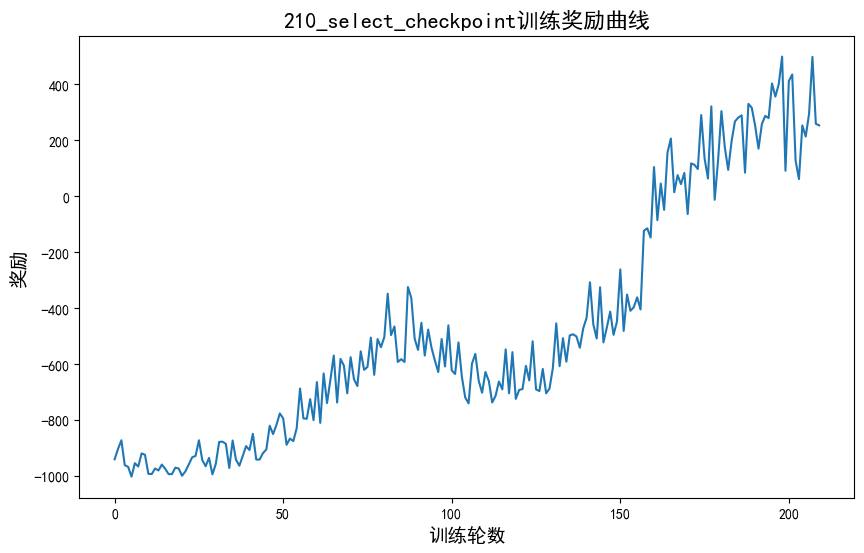

In [10]:
plot_data(plot_title=f"{agent.model_name}训练奖励曲线",
          xlabel="训练轮数",
          ylabel="奖励",
          data_sets=[episode_rewards],
          save_path=save_plot_path)
logging.info(f"奖励图表已保存: {save_plot_path}")

### 测试模型

仿真进度: 10001it [00:00, 14521.24it/s]                          
仿真进度: 10001it [00:08, 1175.52it/s]                          


9258.5


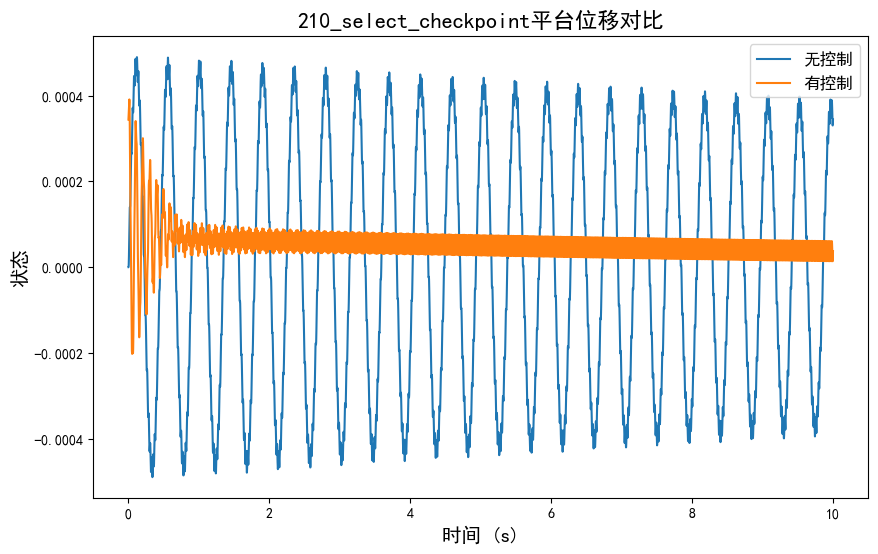

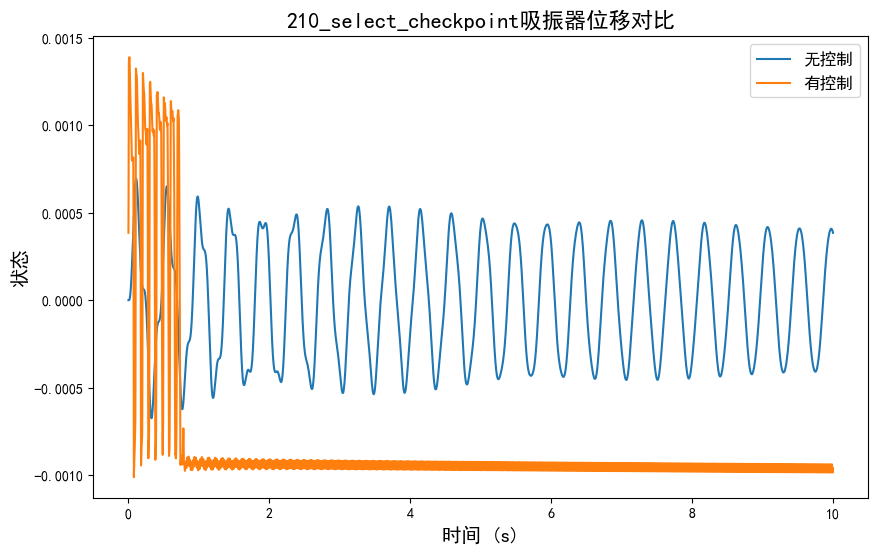

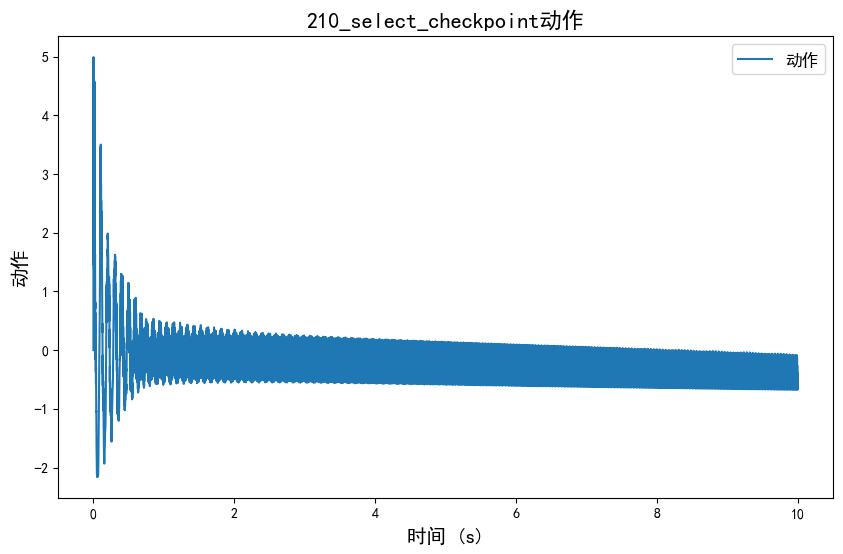

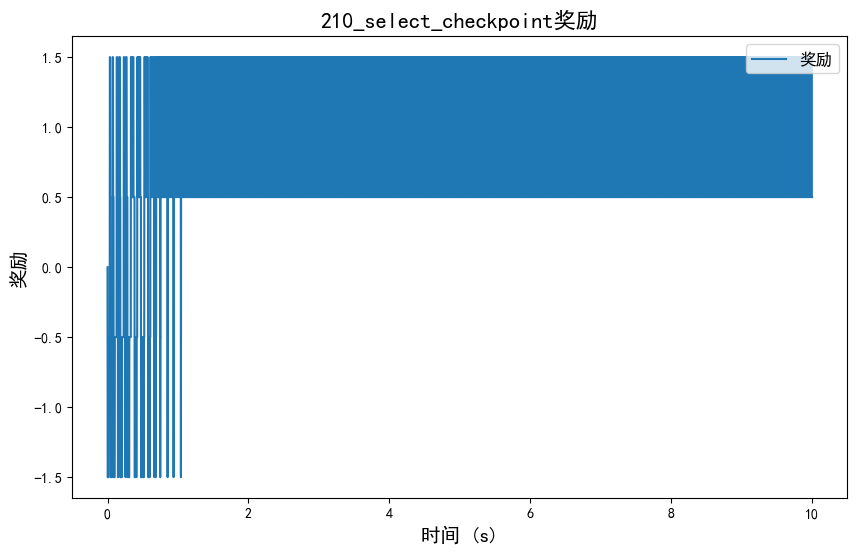

In [14]:
# 运行测试
test_env = ElectromagneticDamperEnv(A, B, C, D, E, Ts=0.001, T=10, 
                                  z_func=sine_disturbance(0.01, 300), r_func=r_func,
                                  obs_indices=observation_indices,
                                  x1_limit=x1_limit)
results_nc = test_env.run_simulation()
results_ddpg = test_env.run_simulation(controller=agent)
print(np.sum(results_ddpg['rewards']))

plot_data(plot_title=f"{agent.model_name}平台位移对比",
          xlabel="时间 (s)",
          ylabel="状态",
          x_values=results_ddpg['times'],
          data_sets=[results_nc['all_states'][:, 3],results_ddpg['all_states'][:, 3]],
          save_path=save_plot_path,
          legends=["无控制", "有控制"]
          )
plot_data(plot_title=f"{agent.model_name}吸振器位移对比",
            xlabel="时间 (s)",
            ylabel="状态",
            x_values=results_ddpg['times'],
            data_sets=[results_nc['all_states'][:, 0],results_ddpg['all_states'][:, 0]],
            save_path=save_plot_path,
            legends=["无控制", "有控制"]
            )

plot_data(plot_title=f"{agent.model_name}动作",
          xlabel="时间 (s)",
          ylabel="动作",
          x_values=results_ddpg['times'],
          data_sets=[results_ddpg['actions']],
          save_path=save_plot_path,
          legends=["动作"]
          )

plot_data(plot_title=f"{agent.model_name}奖励",
          xlabel="时间 (s)",
          ylabel="奖励",
          x_values=results_ddpg['times'],
          data_sets=[results_ddpg['rewards']],
          save_path=save_plot_path,
          legends=["奖励"]
          )
